(entropy_notebook)=
# Entropia

```{admonition} Obiettivi di apprendimento
Dopo aver completato questo capitolo, acquisirete le competenze per:

- comprendere il concetto di entropia;
- comprendere il concetto di divervenza di Kullback-Leibler (KL);
- calcolare la divergenza KL dall'entropia;
```

Nel contesto della statistica bayesiana, è cruciale confrontare diversi modelli predittivi per identificare quello che meglio si adatta ai dati disponibili. Una metrica essenziale in questo confronto è la Expected Log Predictive Density (ELPD), che misura l'accuratezza con cui un modello può prevedere nuovi dati. Non essendo possibile calcolare direttamente l'ELPD, a causa della necessità di conoscere il meccanismo generatore dei dati $ p_t(y) $, ci affidiamo a una stima approssimativa fornita dalla distribuzione predittiva a posteriori del modello, $ p(\tilde{y} | y) $.

Per ottenere una stima più accurata della capacità di generalizzazione di un modello su futuri set di dati, utilizziamo metodi di stima dell'ELPD basati sulla validazione incrociata. Questa tecnica consiste nell'addestrare il modello su un sottoinsieme di dati e testarlo su un altro, isolando così le prestazioni del modello dalle variazioni casuali presenti nei dati. Il risultato di questo processo è l'indice di Leave-One-Out Cross-Validation (LOO-CV), fondamentale per comparare diversi modelli.

La differenza nei valori di Leave-One-Out Cross-Validation (LOO-CV) tra due modelli, accompagnata dal calcolo dell'errore standard associato a questa differenza, ci consente di determinare se esiste una differenza robusta nelle prestazioni tra i due modelli. Se il rapporto tra questa differenza di LOO-CV e il relativo errore standard supera il valore di 2, possiamo concludere che i modelli mostrano differenze sostanziali. Questo indica che le variazioni osservate non sono casuali ma riflettono una superiorità effettiva di un modello rispetto all'altro.

In questo capitolo, esploreremo il concetto di entropia, essenziale per quantificare l'incertezza nelle distribuzioni di probabilità. L'entropia di una variabile casuale rappresenta la media della sua imprevedibilità. Approfondiremo anche il modo in cui l'entropia può essere impiegata per misurare la "distanza" tra un modello teorico e i dati osservati, introducendo il concetto di divergenza di Kullback-Leibler (KL). Questa metrica quantifica le discrepanze tra due distribuzioni probabilistiche, fornendo una misura di quanto efficacemente un modello rappresenti le osservazioni empiriche. Il capitolo successivo presenterà un'analisi della tecnica di Validazione Incrociata Leave-One-Out, impiegata per calcolare un'approssimazione della divergenza KL, nota come LOO-CV.

## Preparazione del Notebook

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
from scipy.special import kl_div
import warnings

warnings.filterwarnings("ignore")

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## La Generalizzabilità dei Modelli e il Metodo Scientifico

La generalizzabilità dei modelli è un concetto chiave nella scienza, essendo uno dei fondamenti del metodo scientifico. Questo principio si riferisce alla capacità di un modello di applicarsi e produrre risultati validi oltre il contesto specifico o il set di dati in cui è stato originariamente sviluppato o testato. Il valore scientifico di un modello è quindi fortemente influenzato dalla sua capacità di generalizzarsi a nuovi dati.

Nella pratica, la generalizzabilità di un modello può essere minacciata da due problemi principali: il sotto-adattamento e il sovra-adattamento. Il sotto-adattamento si verifica quando un modello è troppo semplice per catturare adeguatamente la complessità dei dati, portando a prestazioni insoddisfacenti sia sui dati di addestramento che su nuovi insiemi di dati. Questo limita gravemente la sua utilità in applicazioni pratiche. Al contrario, il sovra-adattamento si manifesta quando un modello è eccessivamente complesso, adattandosi troppo fedelmente al rumore o alle peculiarità specifiche del set di dati di addestramento a discapito della capacità di generalizzare a nuovi dati.

L'approccio bayesiano alla modellazione consente di gestire in modo efficace la necessità di un compromesso tra complessità del modello e adattamento ai dati. La selezione di modelli, come descritto da {cite:t}`McElreath_rethinking`, è un processo che richiede di mediare tra la semplicità del modello e la sua capacità di rappresentare fedelmente la realtà dei dati.

Una pratica comune nella scelta tra modelli alternativi si basa sul principio del rasoio di Ockham, che predilige le spiegazioni più semplici in presenza di multiple teorie equivalenti per un fenomeno. Tuttavia, questo principio da solo non è sufficiente: è essenziale che il modello scelto descriva accuratamente i dati.

La metodologia prevalente nella selezione dei modelli è spesso centrata sull'uso dei valori-p, ma come evidenziato da {cite:p}`McElreath_rethinking`, questo approccio è problematico e privo di una solida giustificazione teorica. 

Un metodo più robusto e fondato scientificamente impiega invece la divergenza di Kullback-Leibler, una misura che valuta quanto un modello approssimi efficacemente la distribuzione reale dei dati, offrendo una stima quantitativa della sua aderenza al processo generativo sottostante. Questo capitolo pone le basi per comprendere il concetto di entropia, essenziale per affrontare nel prossimo capitolo la divergenza di Kullback-Leibler e le sue implicazioni nella selezione di modelli.

### Cos'è l'Entropia dell'Informazione?

L'entropia dell'informazione, un concetto introdotto da Claude Shannon, rappresenta uno dei fondamenti della teoria dell'informazione. Questa grandezza matematica quantifica l'incertezza o la sorpresa legata alla ricezione di un messaggio, calcolando quanto sia imprevedibile un messaggio in base alla probabilità degli eventi che lo costituiscono. Gli eventi che si verificano con alta probabilità sono considerati meno informativi perché prevedibili; al contrario, quelli meno probabili, essendo inaspettati, trasmettono più informazione.

L'entropia di un evento, determinata dalla sua probabilità $ p $, si calcola con la formula:

$$ H(p(x)) = -\log_2(p(x)) = \log_2 \left(\frac{1}{p(x)}\right). $$

Il logaritmo è espresso in base 2 perché in questo contesto l'informazione è misurata in bit. Un bit, che sta per "cifra binaria", rappresenta una scelta tra due opzioni equiprobabili.

È importante notare che la base del logaritmo può variare: non ci sono unità intrinseche per misurare la sorpresa. Ad esempio, l'uso della base 2, comune nelle telecomunicazioni, porta a misurare l'informazione in "bit". Al contrario, l'adozione della base $ e $, tipica nella fisica statistica, porta a misurazioni in "nats", o "cifre naturali".

Per illustrare, consideriamo alcuni esempi pratici, implementati in Python:

In [3]:
import math

def calcola_entropia(p):
    if p == 0 or p == 1:
        return 0  # Non c'è incertezza se l'evento è certo o impossibile
    else:
        return -p * math.log2(p)

# Esempi di probabilità
probabilità = [0.0, 0.1, 0.5, 0.9, 1.0]

# Calcolo dell'entropia per ciascuna probabilità
entropie = {p: calcola_entropia(p) for p in probabilità}

print(entropie)

{0.0: 0, 0.1: 0.33219280948873625, 0.5: 0.5, 0.9: 0.13680278410054494, 1.0: 0}


L'output di questo script mostra che l'entropia è massima per eventi con probabilità intermedia (0.5) e minima (zero) per eventi certi o impossibili.

In generale, possiamo dunque dire che l'entropia raggiunge il suo valore massimo in condizioni di completa equiprobabilità, ovvero quando ogni esito possibile di un evento ha esattamente la stessa probabilità di verificarsi. Questa condizione rappresenta il massimo grado di imprevedibilità, poiché non esistono indizi che possano aiutare a prevedere quale esito si verificherà.

Al contrario, l'entropia è minima, assumendo un valore di zero, quando l'esito di un evento è completamente certo. Questo avviene quando uno degli esiti possibili ha una probabilità di 1, eliminando qualsiasi forma di incertezza o sorpresa. In pratica, ciò significa che non c'è alcuna informazione da guadagnare nell'osservare l'evento, poiché l'esito è già noto in anticipo.

### Additività dell'Entropia per Eventi Indipendenti

L'entropia mostra una proprietà di additività nel caso di eventi indipendenti. Questo significa che, se due o più eventi indipendenti si verificano, l'entropia totale associata alla loro combinazione è uguale alla somma delle entropie di ciascun evento preso singolarmente. Questa caratteristica deriva dalla proprietà additiva dei logaritmi, che permette di sommare le entropie individuali per ottenere l'entropia complessiva.

#### Entropia di una Variabile Casuale Discreta

Prendiamo in considerazione una variabile casuale discreta $ X $, che può assumere i valori $ a_1, a_2, \ldots, a_n $ con le relative probabilità $ p_1, p_2, \ldots, p_n $, dove la somma totale delle probabilità è 1. L'entropia di $ X $ è calcolata come la somma pesata delle entropie di ciascun possibile esito:

$$ H(X) = -\sum_{i=1}^{n} p_i \log_2(p_i). $$

Questa formula riflette la somma delle incertezze associate ad ogni possibile esito della variabile casuale, con ogni termine $ p_i \log_2(p_i) $ che rappresenta la quantità di informazione fornita dall'occorrenza di ciascun esito.

Il segno negativo riflette il fatto che gli esiti più probabili contribuiscono meno alla sorpresa complessiva.

#### Entropia di una Variabile Casuale Continua

Nel caso di variabili continue, l'entropia viene generalizzata usando un integrale:

$$ H(X) = -\int p(x) \log_2(p(x)) \, dx, $$

dove $ p(x) $ è la funzione di densità di probabilità di $ X $. 

### Divergenza di Kullback-Leibler: Uno Strumento per Confrontare Distribuzioni Probabilistiche

La Divergenza di Kullback-Leibler (KL), introdotta da Kullback e Leibler nel 1951, estende il concetto di entropia di Shannon. Mentre l'entropia misura l'incertezza di una singola distribuzione di probabilità, la divergenza KL valuta quanto una distribuzione di probabilità $ Q $ differisca da un'altra distribuzione di riferimento $ P $. Entrambe le distribuzioni devono descrivere la stessa variabile aleatoria $ X $.

#### Calcolo della Divergenza KL

Supponiamo che la variabile casuale $ X $ segua la distribuzione $ P $. L'entropia di Shannon, che quantifica la sorpresa media risultante dall'osservazione di esiti distribuiti secondo $ P $, si calcola come:

$$
H(P) = -\sum_x p(x) \log(p(x)).
$$

Per valutare quanto sarebbe sorprendente osservare $ P $ attraverso la lente di una distribuzione diversa $ Q $, calcoliamo l'entropia incrociata, definita come:

$$
H(P, Q) = -\sum_x p(x) \log(q(x)).
$$

Questa misura rappresenta la sorpresa attesa se utilizzassimo $ Q $ anziché $ P $ per descrivere la variabile aleatoria $ X $.

La divergenza KL, che è la differenza tra l'entropia di $ P $ e l'entropia incrociata tra $ P $ e $ Q $, si esprime come:

$$
D_{KL}(P \parallel Q) = \sum_x p(x) \big(\log(p(x)) - \log(q(x))\big).
$$

Alternativamente, la formula precedente può essere riscritta utilizzando il rapporto tra i logaritmi:

$$
D_{KL}(P \parallel Q) = \sum_x p(x) \log \left(\frac{p(x)}{q(x)}\right).
$$

In queste formule, $ \left(\log(p(x)) - \log(q(x))\right) $ rappresenta il "costo" di sorpresa per ciascun esito $ x $, ponderato dalla probabilità $ p(x) $ di tale esito secondo la distribuzione originale $ P $. Questo costo quantifica quanto $ Q $ sia inadeguata a modellare o descrivere $ P $.

La divergenza KL quantifica "quanto siamo sorpresi" nell'utilizzare $ Q $ per prevedere eventi distribuiti secondo $ P $ e riflette l'informazione che viene "persa" quando $ Q $ è usata al posto di $ P $.

In conclusione, la divergenza KL si basa su due misure fondamentali:

- **Entropia di $ P $**: Misura l'incertezza interna di $ P $.

- **Entropia incrociata tra $ P $ e $ Q $**: Quantifica l'incertezza quando $ Q $ è utilizzata per stimare $ P $.

Così, la divergenza KL rappresenta la differenza tra l'entropia di $ P $ e l'entropia incrociata tra $ P $ e $ Q $, e mette in evidenza quanto l'uso di $ Q $ al posto di $ P $ incrementi l'incertezza o la sorpresa.

Per fare un esempio, supponiamo che $ P $ e $ Q $ siano due distribuzioni di probabilità su un insieme finito di possibili esiti, ad esempio {0, 1, 2}. Per semplicità, consideriamo che $ P $ e $ Q $ siano definite come segue:

- $ P $ è la distribuzione "vera": $ P = [0.1, 0.6, 0.3] $
- $ Q $ è una distribuzione alternativa che usiamo per la stima: $ Q = [0.2, 0.5, 0.3] $

In [4]:
# Definizione delle distribuzioni
P = np.array([0.1, 0.6, 0.3])
Q = np.array([0.2, 0.5, 0.3])

# Calcolo della divergenza KL da P a Q
KL_divergence = np.sum(kl_div(P, Q))

print(f"Divergenza KL da P a Q: {KL_divergence:.4f}")

Divergenza KL da P a Q: 0.0401


Nel codice precedente, `kl_div(P, Q)` calcola la divergenza KL elemento per elemento dell'array. Essa calcola $\sum_x p(x) \log \left(\frac{p(x)}{q(x)}\right)$ per ogni esito $ x $, che è esattamente il termine $ p(x) \log \left(\frac{p(x)}{q(x)}\right) $ descritto nella formula della divergenza KL. Utilizziamo poi `np.sum` per sommare tutti i contributi individuali e ottenere il valore totale della divergenza KL.

Questo esempio fornisce un calcolo diretto della divergenza KL tra due distribuzioni, mostrando come una distribuzione $ Q $ possa essere inadeguata nel modellare una distribuzione $ P $, con un focus sul "costo" di sorpresa per ogni esito.

In un due altri esempi, rendiamo via via $Q$ più diverso da $P$. Notiamo come la divergenza KL aumenta.

In [5]:
P = np.array([0.1, 0.6, 0.3])
Q = np.array([0.35, 0.3, 0.35])
KL_divergence = np.sum(kl_div(P, Q))
print(f"Divergenza KL da P a Q: {KL_divergence:.4f}")

Divergenza KL da P a Q: 0.2444


In [6]:
P = np.array([0.1, 0.6, 0.3])
Q = np.array([0.6, 0.3, 0.1])
KL_divergence = np.sum(kl_div(P, Q))
print(f"Divergenza KL da P a Q: {KL_divergence:.4f}")

Divergenza KL da P a Q: 0.5663


### Applicazione della Divergenza KL nella Selezione di Modelli

La divergenza di Kullback-Leibler (KL) è un indice fondamentale nella selezione di modelli statistici. L'obiettivo è identificare il modello $ Q $ che minimizza $ D_{KL}(P \parallel Q) $, ovvero ridurre al minimo la differenza $ H(P) - H(P, Q) $. Questo significa minimizzare l'errore introdotto nell'approssimare la distribuzione vera $ P $ con il modello $ Q $.

#### Proprietà Importanti

- **Non-negatività:** $ D_{KL}(P \parallel Q) \geq 0 $. Il valore è zero solamente quando $ P $ e $ Q $ sono identiche, indicando una perfetta corrispondenza.
- **Asimmetria:** $ D_{KL}(P \parallel Q) \neq D_{KL}(Q \parallel P) $. Questa proprietà evidenzia che la "distanza" percepita dal modello $ Q $ verso $ P $ non è equivalente se misurata nella direzione inversa.

#### Selezione dei Modelli Statistici

Nel contesto della selezione di modelli statistici, l'intento principale è quello di scegliere il modello $ Q $ che riduca al minimo la divergenza KL rispetto alla distribuzione "vera" $ P $ dei dati. Tuttavia, la distribuzione $ P $ è spesso sconosciuta o non direttamente osservabile.

Di fronte a tale incertezza, i ricercatori e gli statistici utilizzano criteri approssimativi per stimare indirettamente la divergenza KL. Tra questi, il Criterio di Informazione di Akaike (AIC) e il Criterio di Informazione Bayesiano (BIC) sono particolarmente utili, in quanto valutano la bontà di adattamento del modello insieme alla sua complessità:

- **Criterio di Informazione di Akaike (AIC):**

  $$
  AIC = 2k - 2\ln(L),
  $$

  dove $ k $ rappresenta il numero di parametri nel modello e $ L $ è la log-verosimiglianza massima ottenuta dal modello. Un valore più basso di AIC indica una minor perdita di informazione, suggerendo un modello preferibile.

Consideriamo un esempio numerico per confrontare AIC con la divergenza KL. Supponiamo di avere un set di dati e due modelli statistici: il primo modello si adatta bene ai dati (modello vero), mentre il secondo è un po' più distante dalla realtà (modello alternativo, ne considereremo 5). Calcoleremo la divergenza KL tra le distribuzioni previste da questi modelli e il Criterio di Informazione di Akaike per valutare la qualità di adattamento dei modelli. 

Per questo esempio, supponiamo di avere un set di dati e due modelli statistici: il primo modello si adatta bene ai dati (modello vero), mentre il secondo è un po' più distante dalla realtà (modello alternativo). Calcoleremo la divergenza KL tra le distribuzioni previste da questi modelli e il Criterio di Informazione di Akaike per valutare la qualità di adattamento dei modelli.

- **Generazione dei dati**: Supponiamo che i dati siano generati da una distribuzione normale con media vera $ \mu = 0 $ e deviazione standard $ \sigma = 1 $.
- **Modello Vero**: Assumiamo che il modello vero conosca i parametri della distribuzione.
- **Modello Alternativo**: Assumiamo che questo modello abbia una deviazione standard leggermente diversa (considereremo 5 modelli diversi$: \sigma = 1.5 fino a 5.0 $).


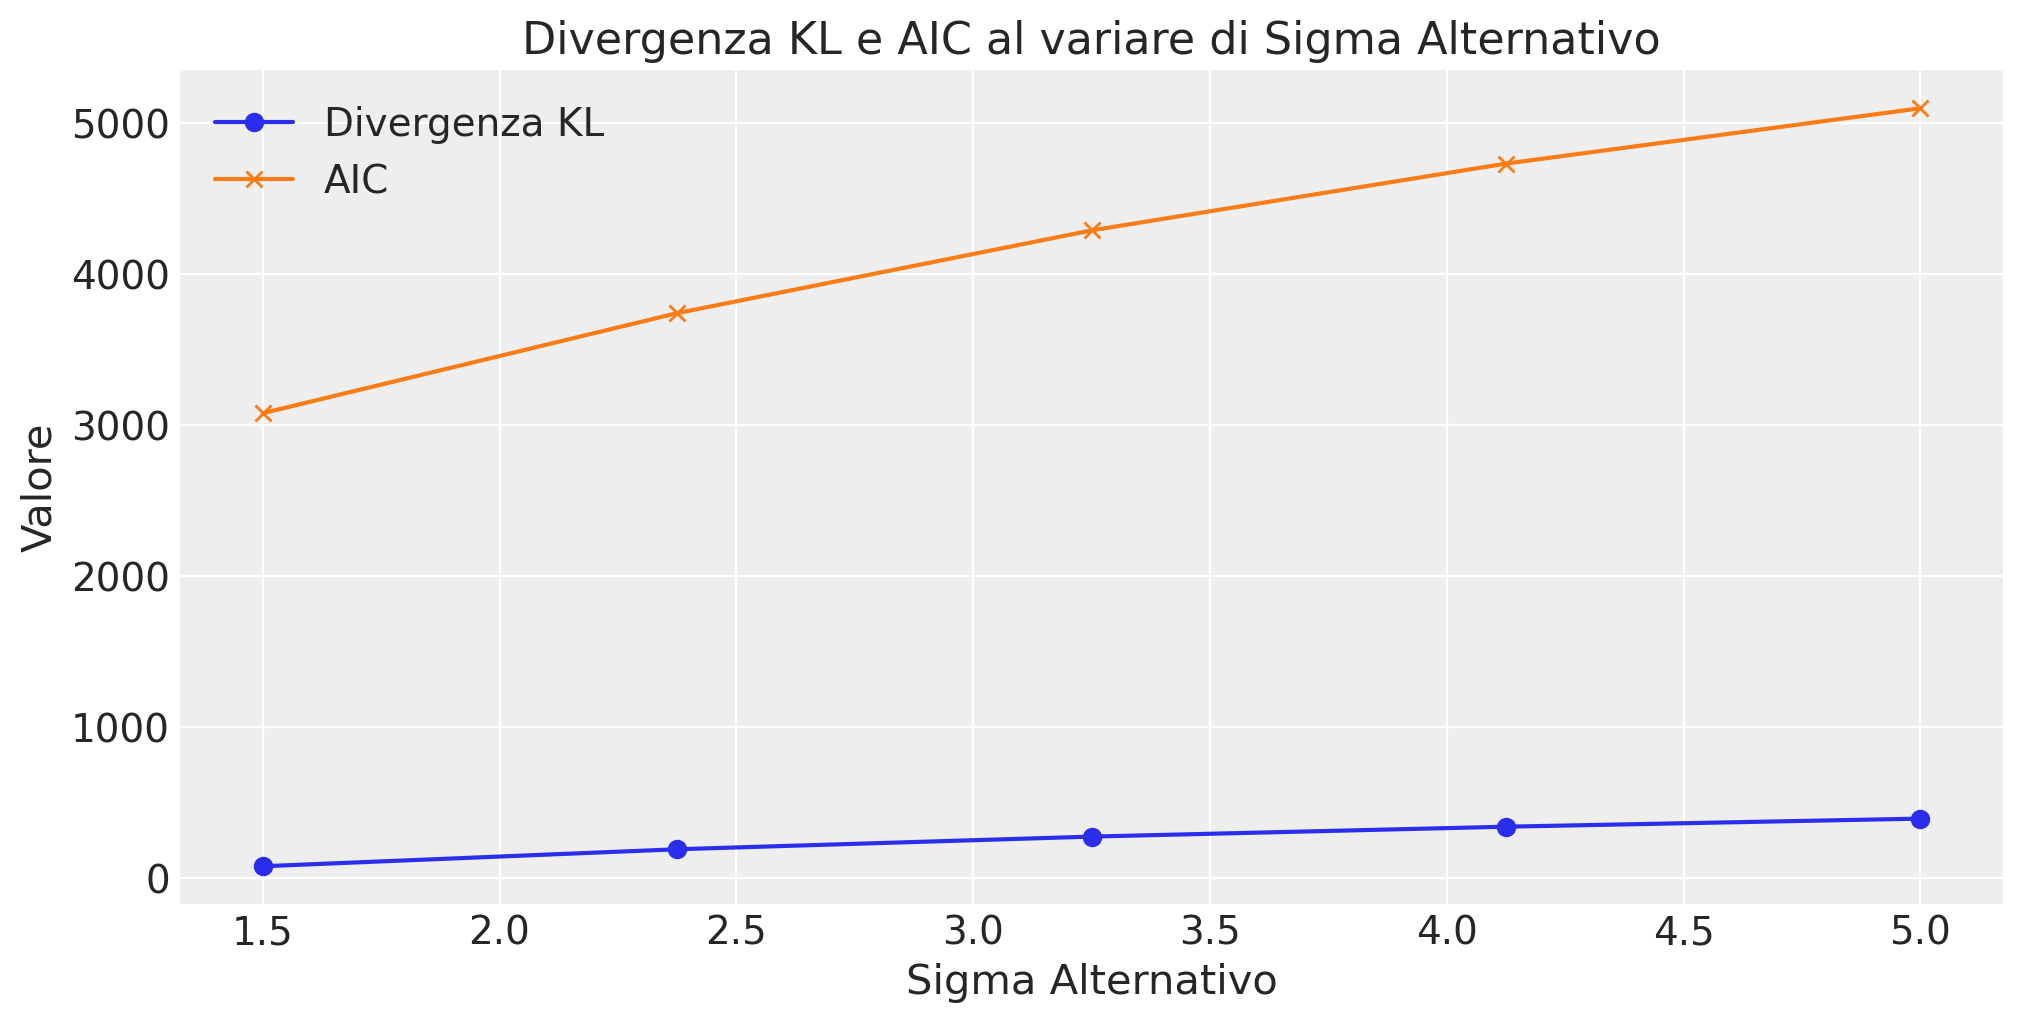

In [7]:
# Generazione dei dati simulati
np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=1000)

# Parametri del modello vero
mu_true, sigma_true = 0, 1

# Variazione di sigma_alt
sigma_alts = np.linspace(1.5, 5.0, 5)
KL_divergences = []
AIC_values = []

# Calcolo della divergenza KL e AIC per ogni sigma_alt
for sigma_alt in sigma_alts:
    p_true = stats.norm.pdf(data, mu_true, sigma_true)
    p_alt = stats.norm.pdf(data, mu_true, sigma_alt)
    KL_divergence = np.sum(p_true * np.log(p_true / p_alt))
    KL_divergences.append(KL_divergence)

    log_likelihood_alt = np.sum(np.log(stats.norm.pdf(data, mu_true, sigma_alt)))
    AIC_alt = (
        2 * 2 - 2 * log_likelihood_alt
    )  # 2 parametri (mu e sigma), nessuna esponenziale
    AIC_values.append(AIC_alt)

# Creazione del grafico
plt.figure(figsize=(10, 5))
plt.plot(sigma_alts, KL_divergences, label="Divergenza KL", marker="o")
plt.plot(sigma_alts, AIC_values, label="AIC", marker="x")
plt.xlabel("Sigma Alternativo")
plt.ylabel("Valore")
plt.title("Divergenza KL e AIC al variare di Sigma Alternativo")
plt.legend()
plt.grid(True)
plt.show()

Si vede che, anche se la scala di misura è diversa tra la divergenza KL e il criterio AIC, all'aumentare della differenza tra la distribuzione vera $P$ e la distribuzione alternativa $Q$, entrambi aumentano.

- **Criterio di Informazione Bayesiano (BIC):**

  $$
  BIC = \ln(n)k - 2\ln(L),
  $$

  dove $ n $ è il numero di osservazioni. Il BIC impone una penalità maggiore per l'incremento dei parametri, rendendolo particolarmente adeguato per dataset di grandi dimensioni.

Entrambi i criteri, AIC e BIC, mirano a bilanciare la complessità del modello con la sua capacità di spiegare i dati, cercando di prevenire il sovra-adattamento. Utilizzando queste metriche, gli analisti possono effettuare scelte più informate nella selezione dei modelli, avvicinandosi all'obiettivo di minimizzare la divergenza KL tra il modello prescelto e la vera distribuzione sottostante dei dati.

## Riflessioni Conclusive

In questo capitolo, abbiamo esaminato il concetto di entropia, evidenziando il suo ruolo fondamentale nel quantificare l'incertezza all'interno delle distribuzioni di probabilità. Abbiamo anche affrontato la questione di come l'entropia possa essere impiegata per valutare la "distanza" tra un modello teorico e i dati reali. A tale scopo, abbiamo introdotto la divergenza di Kullback-Leibler (KL), una misura che quantifica le discrepanze tra due distribuzioni di probabilità. 

Nel capitolo successivo, approfondiremo ulteriormente il tema della divergenza KL. Esploreremo come questo strumento possa essere utilizzato per confrontare modelli teorici con dati empirici e ci concentreremo su come possa fornirci una comprensione più dettagliata dell'adattamento di un modello alla realtà che intende rappresentare. Questa esplorazione ci permetterà di valutare più accuratamente la validità e la generalizzabilità dei modelli scientifici nel loro tentativo di catturare e interpretare la complessità dei fenomeni oggetto di studio.

## Informazioni sull'Ambiente di Sviluppo

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Mon May 06 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.22.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
matplotlib: 3.8.4
arviz     : 0.18.0
pandas    : 2.2.2
scipy     : 1.13.0

Watermark: 2.4.3

